In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

2024-05-10 17:58:29.354587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 17:58:31.292883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = "../../00.Data/07.ML/data/Face Mask Dataset/"

dataset = {
    "image_path" : [],
    "mask_status" : [],
    "where" : []
}

for where in os.listdir(path) :
    for status in os.listdir(path+"/"+where) :
        for image in glob.glob(path+where+"/"+status+"/"+"*.png") :
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)

dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,../../00.Data/07.ML/data/Face Mask Dataset/Tra...,WithoutMask,Train
1,../../00.Data/07.ML/data/Face Mask Dataset/Tra...,WithoutMask,Train
2,../../00.Data/07.ML/data/Face Mask Dataset/Tra...,WithoutMask,Train
3,../../00.Data/07.ML/data/Face Mask Dataset/Tra...,WithoutMask,Train
4,../../00.Data/07.ML/data/Face Mask Dataset/Tra...,WithoutMask,Train


With Mask: 5909
Without Mask: 5883


/tmp/ipykernel_471644/1809476592.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"With Mask:", dataset.value_counts("mask_status")[0])
/tmp/ipykernel_471644/1809476592.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Without Mask:", dataset.value_counts("mask_status")[1])


<Axes: xlabel='mask_status', ylabel='count'>

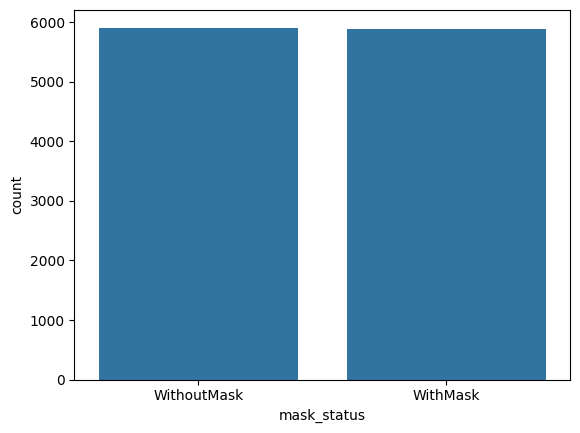

In [3]:
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

sns.countplot(x = dataset["mask_status"])

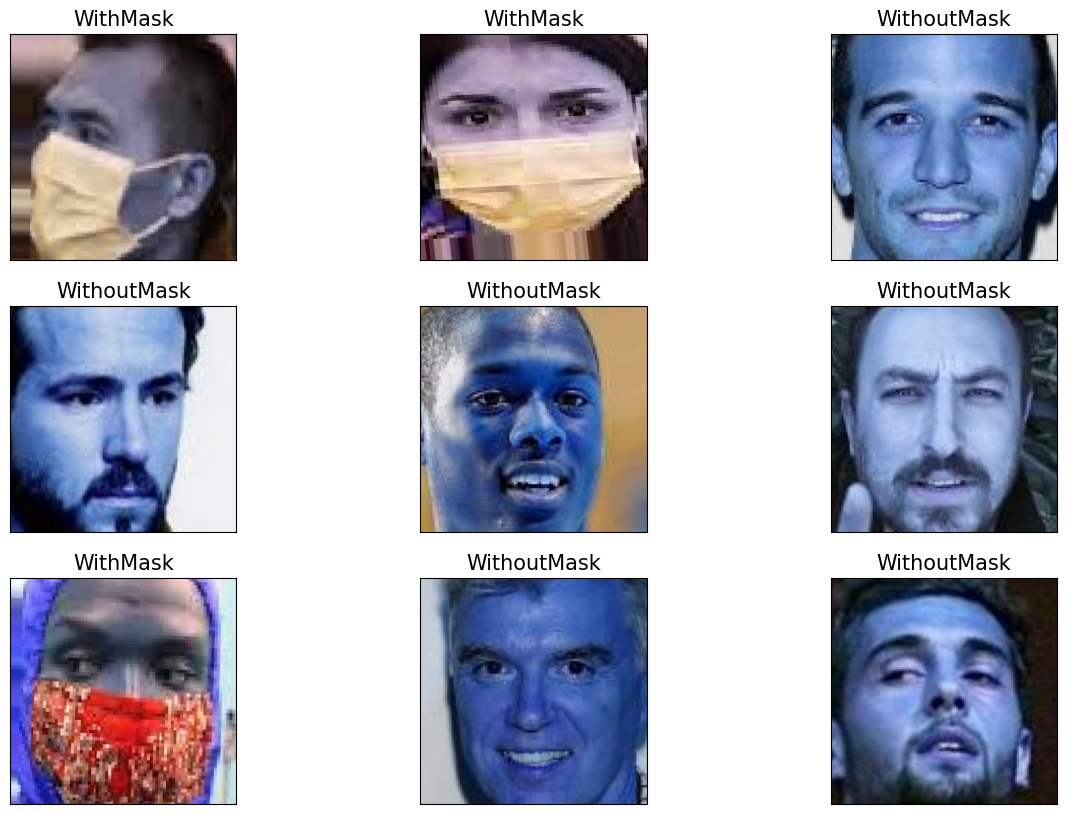

In [4]:
plt.figure(figsize = (15,10))
for i in range(9) :
  random = np.random.randint(1, len(dataset))
  plt.subplot(3, 3, i+1)
  plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))
  plt.title(dataset.loc[random, "mask_status"], size=15)
  plt.xticks([])
  plt.yticks([])
plt.show()

In [5]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]
print(train_df.head(10))

                                          image_path  mask_status  where
0  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
1  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
2  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
3  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
4  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
5  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
6  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
7  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
8  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train
9  ../../00.Data/07.ML/data/Face Mask Dataset/Tra...  WithoutMask  Train


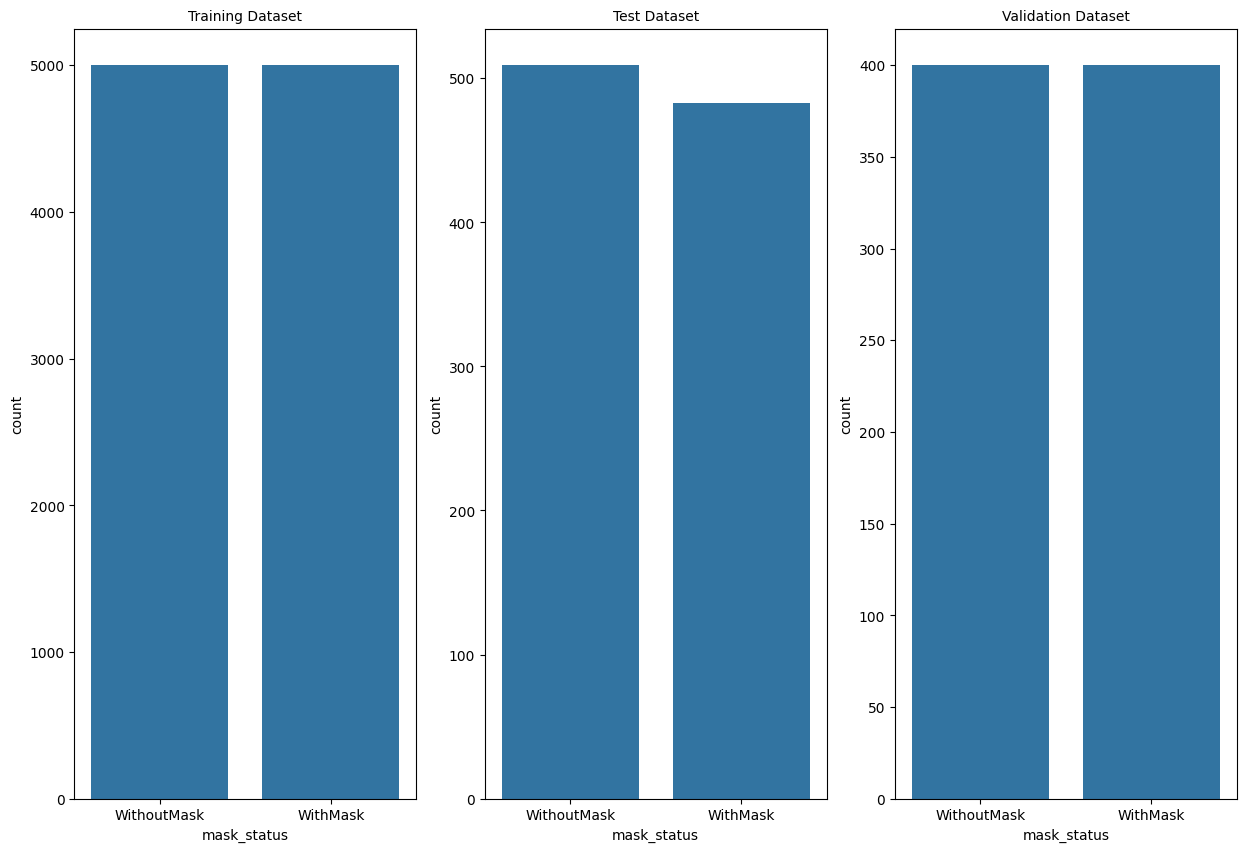

In [6]:
plt.figure(figsize = (15,10))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size=10)
plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size=10)
plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size=10)
plt.show()

In [12]:
train_df = train_df.reset_index().drop("index", axis=1)
data = []
image_size = 150

for i in range(len(train_df)) :
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    if train_df["mask_status"][i] == "WithMask" :
        data.append([new_image_array, 1])
    else :
        data.append([new_image_array, 0])

In [13]:
#data = np.array(data)
np.random.shuffle(data)
type(data)

list

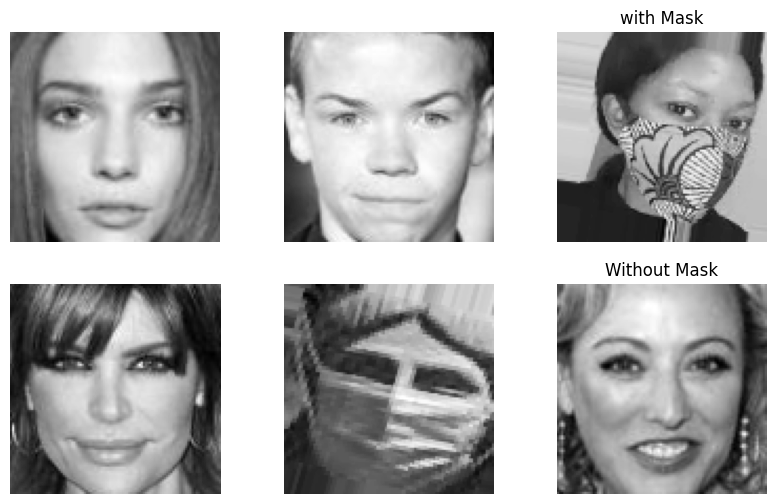

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for row in range(2) :
    for col in range(3) :
        image_index = row*100+col

        ax[row, col].axis("off")
        ax[row, col].imshow(data[image_index][0], cmap = 'gray')

    if data[image_index][1] == 0 :
        ax[row, col].set_title("Without Mask")
    else :
        ax[row, col].set_title("with Mask")

plt.show()

In [15]:
x = []
y = []

for image in data :
    x.append(image[0])
    y.append(image[1])

x = np.array(x)
y = np.array(y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=50)

In [16]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5),strides=(1,1), padding='same', activation='relu', input_shape=(150,150,1)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, (2,2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

/home/han/venv/ML/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-10 17:59:35.575373: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 152.59MiB (rounded to 160000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-10 17:59:35.575473: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-05-10 17:59:35.575503: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chu

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[40000,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 

In [ ]:
import time

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

x_train = x_train.reshape(len(x_train), x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(len(x_val), x_val.shape[1], x_val.shape[2], 1)

history = model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5


2024-05-10 16:54:56.040087: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 180000000 exceeds 10% of free system memory.
2024-05-10 16:54:56.209454: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 180000000 exceeds 10% of free system memory.
I0000 00:00:1715327699.388386  185565 service.cc:145] XLA service 0x7977ec007580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715327699.388465  185565 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-05-10 16:54:59.468664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 16:54:59.943206: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  5/250 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.4722 - loss: 1353.5664

I0000 00:00:1715327706.919211  185565 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8087 - loss: 130.5013
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9773 - loss: 0.0716
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9817 - loss: 0.0508
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9869 - loss: 0.0422
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9855 - loss: 0.0410


In [ ]:
prediction = (model.predict(x_val) > 0.5).astype("int32")
print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

2024-05-10 16:55:54.103438: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45000000 exceeds 10% of free system memory.
2024-05-10 16:55:54.233139: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45000000 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       983
           1       0.97      0.95      0.96      1017

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

[[954  29]
 [ 53 964]]
